### Side Info

In [ ]:
import cupy as cp
import numpy as np
array_cpu = np.random.randint(0, 255, size=(2000, 2000))
array_cpu.nbytes / 1e6

32.0

In [ ]:
%%timeit

cp.asarray(array_cpu)

100 loops, best of 5: 5.76 ms per loop


In [ ]:
type(array_gpu)

cupy._core.core.ndarray

In [ ]:
!nvidia-smi

Mon May 16 09:11:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    59W / 149W |    195MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Lab4: GPU Programming Lab

### Name: Write your names (Group)


This lab is an introduction of GPU programming with cuda using python. The consists of 4 questions and a homework. 

- <font color='red'><b> After each exercise, write a detailed summary explaining what you have done, your observations and  conclusions. </b></font>
- <font color='red'><b> Make sure to write your name and your partner name (as registred in Halmstad University) in the name section above. </b></font>
    
- <font color='red'><b> You can do the lab in a group of a maximum of two students. </b></font>

- <font color='red'><b> Only one of the students upload the lab to the blackboard. </b></font>

# CUDA
CUDA is a parallel programming platform and an API that facilitates the access to the CUDA-Enabled GPU functuonality for general purpose computing. It allows speeding up the software by utilizing the GPU power for the parallelizable part of the computation. Many Deep Learning platforms like tenserflow, keras, pytorch and others, rely on CUDA for their computations.

## Common CUDA terminology:
- <b>Host:</b> The CPU
- <b>Device:</b> The GPU
- <b>Host Memory:</b> The system main memory
- <b>Device Memory:</b> The GPU onboard memory
- <b>kernel:</b> A function that runs on the Device

Threads are organized into a grid of blocks, where each block contains a subset of the threads that can cooperate using a block shared memory and can synchronize within each block.

<img src='https://drive.google.com/uc?id=1QzXBVWki0M80KKY_CPzQu1ivE3fAcf2U' width="50%" height="50%"></img>


Parallel portions of an application are executed on the device (GPU) as kernels, where an array of threads excutes each kernel. Each thread has an ID, by which it controls the portion of the data to excute the Kernel. All threads runs the same code on different portions of the data. Grids and Blocls can be organized as 1D, 2D, or 3D arrays. 

<img src='https://drive.google.com/uc?id=1vqh749XFQhfZwq7m7E-VXscBblh58mei' width="50%" height="50%"></img>


# Numba
CUDA is designed to work with C++, but in this Lab we will work with Numba; a Python JIT compiler that translates subsets of the code into machine code, and enables writing a parallel GPU algorithms in Python

## Numba installation


conda install numba

pip install numba

In [ ]:
!pip install numba

# Kernel 
- A Kernel is declared as a function with @cuda.jit decorator.
- A Kernel function cannot have a return value and manages outputs as input-output arrays

Always check that you are accessing valid memory

In [1]:
import numpy as np
import math
import numba as nb
from numba import cuda
import time

In [ ]:
A = np.random.randint(0, 3, size=(3, 4))
A

array([[0, 0, 0, 0],
       [0, 2, 0, 2],
       [1, 0, 0, 2]])

In [ ]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # code here
    pass


To invoc a kernal you have to specify number of blocks in the grid, and the number of threads per block. This can be done by specifying the number of threads per block and calculating how many blocks are required in the grid based on the size of the data.

<font color=red>Important note: In the case that the data size is not divisable by the the number of thread per block, we take the ceiling of the number to reserve an extra block for the remaining part of the data. So the threads in the last block will not be fully occupied.</font>

In [ ]:
# kernel invocation
data = np.ones(256)
threadsperblock = 32
blockspergrid = math.ceil(len(data)/threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)


In [ ]:
len(data)/9

28.444444444444443

In [ ]:
math.ceil(len(data)/9)

29

## Exercise 1: Element-wise operation

The following kernel takes 1D array as input and computes the element-wise cube-root x^(1/3) for each element in the array. This an example of an arbitrary costy operation.

- pos: holds the position in the data on which the thread will work.
- Always check if the position exceeds the length of the data for the sake of cases when the data length is not devisable by the number of threads per block.

<img src='https://drive.google.com/uc?id=1AndzjaLH-Lc7N4cg1Ue_zEB3EyJni89N' width="50%" height="50%"></img>

Read the code below and compute the position of the thread on which it will do the computation in the output array.

In [ ]:
# kernel decleration
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    # Compute flattened index inside the array
    # pos = cuda.grid(1) # this function returns the same value for the position in a 1D grid
    
    #TODO: compute the correct pos value based on the tread index and the block index and the block width
    pos = (bx * bw) + tx
    
    if pos < io_array.size:
        io_array[pos] = io_array[pos]**(1/3)
        

# kernel invocation
data = np.ones(2048)
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)


In [ ]:
data = np.ones(10000000)
%timeit np.cbrt(data)

1 loop, best of 5: 239 ms per loop


In [ ]:
data = np.ones(20000000)
%timeit np.cbrt(data)

1 loop, best of 5: 466 ms per loop


In [ ]:
data = np.ones(30000000)
%timeit np.cbrt(data)

1 loop, best of 5: 729 ms per loop


In [ ]:
data = np.ones(40000000)
%timeit np.cbrt(data)

1 loop, best of 5: 955 ms per loop


In [ ]:
data = np.ones(50000000)
%timeit np.cbrt(data)

1 loop, best of 5: 1.17 s per loop


In [ ]:
data = np.ones(10000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

10 loops, best of 5: 25.6 ms per loop


In [ ]:
data = np.ones(20000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

10 loops, best of 5: 59 ms per loop


In [ ]:
data = np.ones(30000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

10 loops, best of 5: 84.7 ms per loop


In [ ]:
data = np.ones(40000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

10 loops, best of 5: 108 ms per loop


In [ ]:
data = np.ones(50000000)
threadsperblock = 1024
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
%timeit my_kernel[blockspergrid, threadsperblock](data)

1 loop, best of 5: 110 ms per loop


In [ ]:
data = 1
del(data)
data = np.ones(1250000000)
(data.nbytes /1e6)

10000.0

In [ ]:
inputs_M = [10, 20, 30, 40, 50]
cpu_times_ms = [239, 466, 729, 955, 1170]
gpu_times_ms = [25.6, 59, 84.7, 108, 110]
normalized = [int(a/b) for a,b in zip(cpu_times_ms, gpu_times_ms)]
normalized

[9, 7, 8, 8, 10]

In [ ]:
inputs_M = [10, 50, 250]
cpu_times_ms = [278, 13500, 68300]
gpu_times_ms = [23.6, 120, 636]
normalized = [int(a/b) for a,b in zip(cpu_times_ms, gpu_times_ms)]
normalized

[11, 112, 107]

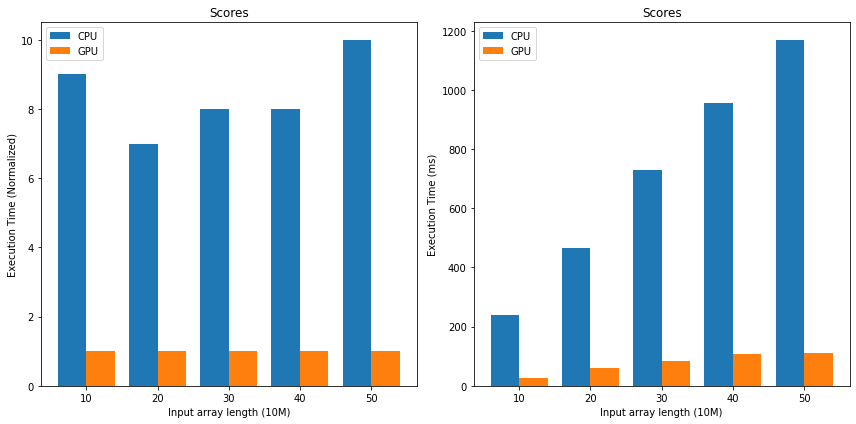

In [ ]:
import matplotlib.pyplot as plt

width = 4  # the width of the bars
base_line = [1,1,1,1,1]
xs = inputs_M
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

ax1.bar([x - width/2 for x in xs], normalized, width, label='CPU')
ax1.bar([x + width/2 for x in xs], base_line, width, label='GPU')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('Input array length (10M)')
ax1.set_ylabel('Execution Time (Normalized)')
ax1.set_title('Scores')
ax1.set_xticks(xs)
ax1.legend()


ax2.bar([x - width/2 for x in xs], cpu_times_ms, width, label='CPU')
ax2.bar([x + width/2 for x in xs], gpu_times_ms, width, label='GPU')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xlabel('Input array length (10M)')
ax2.set_ylabel('Execution Time (ms)')
ax2.set_title('Scores')
ax2.set_xticks(xs)
ax2.legend()
# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Comparison between the previous kernel and Numpy 
- Try different array sizes and compare between CPU (using numpy) and GPU.
- Plot a graph that shows the array sizes on the x axis and the computation time on the y axis of both your kernel and numpy (on the same plot). 
- Is there a relation between the size of the array and difference in performance? Explain what you notice.

### Exercise 1: Results


## Exercise 2: Matrix Multiplication

In matrix multiplication, every kernel will be reponsible of computing one element of the output matrix. It reads one row from the first matrix (A) and one column form the second matrix (B) and computes the dot product of these two vectors and place it in the corresponding cell in the output matrix (C) as shown in the following figure.

<img src='https://drive.google.com/uc?id=16EMuj46QLdwKmIDPU0P6AepZ9SNssb2s' width="50%" height="50%"></img>

Write a kernel to do the multiplication of two matrices.

In [ ]:
# CUDA kernel
@cuda.jit
def mat_mul(A, B, C):
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    
    if row < A.shape[0] and col < B.shape[1]:
        prod = 0.
        for k in range(A.shape[1]):
          prod += A[row, k] * B[k, col]
        C[row, col] = prod




### Create a host function to invoke the kernel

It is a good practice to manually copy the matrices to Device (the GPU memory) using "cuda.to_device" to reduce the unnecessary data transfer between the device and the host.


To test the kernel "mat_mul" we prepare the host function "gpu_dot" which will take two matrices as parameters and returns the output matrix. The job of this host function is to perpare the data and to invoke the kernel.

Read the code below and calculate how many blocks are required to start the kernel. Use the calculated values to invoke the kernel.

In [ ]:
def gpu_dot(A, B):
    #Copy the input matrices to the gpu
    start_copy_time = time.time()
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[1]), np.float32)
    
    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (32, 32)
    
    #TODO: Calculate how many blocks are required
    blockspergrid_x = math.ceil(A.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(B.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    dt = time.time()-start_copy_time
    print(f'Copying Input to GPU time: {dt} s')
    start_mult_time = time.time()
    
    #TODO: Start the kernel based on the calculated grid 
    mat_mul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

    dt = time.time()-start_mult_time
    print(f'Multiplication Time: {dt} s')
    # Copy the result back to the host
    start_copy_back_time = time.time()
    C = C_global_mem.copy_to_host()
    dt = time.time()-start_copy_back_time
    print(f'Copy result back time: {dt} s')
    dt = time.time()-start_copy_time
    print(f'Total time: {dt} s')
    return C



In [ ]:
# Input Test arrays
A = np.full((2048, 2048), 3, np.float32) # matrix containing all 3's
B = np.full((2048, 2048), 4, np.float32) # matrix containing all 4's

#Test the host function
C = gpu_dot(A,B)
print(f'Input Shapes:A:{A.shape}, B:{B.shape}')
print('Output Shape:', C.shape)
print('Output:',C)
print(f'{C.nbytes / 1e6} MB ')

Copying Input to GPU time: 0.1419696807861328 s
Multiplication Time: 0.36777234077453613 s
Copy result back time: 1.9649507999420166 s
Total time: 2.4759016036987305 s
Input Shapes:A:(2048, 2048), B:(2048, 2048)
Output Shape: (2048, 2048)
Output: [[24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 ...
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]
 [24576. 24576. 24576. ... 24576. 24576. 24576.]]
16.777216 MB 


In [ ]:
# Input Test arrays
A = np.full((16384, 2048), 3, np.float32) # matrix containing all 3's
B = np.full((2048, 16384), 4, np.float32) # matrix containing all 4's

### Testing the calculations time compared to numpy

In [ ]:
start_time = time.time()
%timeit np.dot(A,B)
dt = time.time()- start_time
print(f'CPU calculation time: {dt} s')

1 loop, best of 5: 242 ms per loop
CPU calculation time: 1.505669355392456 s


### Comparison between the previous gpu_dot and Numpy.dot
- Try different array sizes and compare between CPU (using np.dot) and GPU (using gpu_dot).
- Plot a graph that shows the array sizes (bacause it is a 2D matrix, you can consider the size to be the hight x width) on the x axis and the computation time on the y axis of both your kernel and numpy (on the same plot). 
- Explain what you notice.

test_values = (()2048,2048)(2048,2048)

In [ ]:
A = np.full((2048, 4096), 3, np.float32) # matrix containing all 3's
B = np.full((4096, 2048), 4, np.float32) # matrix containing all 4's
C = gpu_dot(A,B)

Copying Input to GPU time: 0.011709213256835938 s
Multiplication Time: 0.0024886131286621094 s
Copy result back time: 3.7905967235565186 s
Total time: 3.805438995361328 s


In [ ]:
start_time = time.time()
%timeit np.dot(A,B)
dt = time.time()- start_time
print(f'CPU calculation time: {dt} s')

1 loop, best of 5: 475 ms per loop
CPU calculation time: 2.9433741569519043 s


In [ ]:
A = np.full((4096, 2048), 3, np.float32) # matrix containing all 3's
B = np.full((2048, 4096), 4, np.float32) # matrix containing all 4's
C = gpu_dot(A,B)

Copying Input to GPU time: 0.013916730880737305 s
Multiplication Time: 0.0014090538024902344 s
Copy result back time: 7.3464415073394775 s
Total time: 7.362177848815918 s


In [ ]:
start_time = time.time()
%timeit np.dot(A,B)
dt = time.time()- start_time
print(f'CPU calculation time: {dt} s')

1 loop, best of 5: 971 ms per loop
CPU calculation time: 5.944607496261597 s


### Exercise 2: Results

#### test 1

In [ ]:
# Input Test arrays
A = np.full((16384, 8192), 3, np.float32) # matrix containing all 3's
B = np.full((8192, 16384), 4, np.float32) # matrix containing all 4's
print(f'Input Shapes:A:{A.shape}, B:{B.shape}')


Input Shapes:A:(16384, 8192), B:(8192, 16384)


In [ ]:
#Test the host function
C = gpu_dot(A,B)
print('Output Shape:', C.shape)
print('Output:',C)
print(f'{C.nbytes / 1e6} MB ')

Copying Input to GPU time: 0.23486018180847168 s
Multiplication Time: 0.0012249946594238281 s
Copy result back time: 84.07591605186462 s
Total time: 84.31268644332886 s
Output Shape: (16384, 16384)
Output: [[98304. 98304. 98304. ... 98304. 98304. 98304.]
 [98304. 98304. 98304. ... 98304. 98304. 98304.]
 [98304. 98304. 98304. ... 98304. 98304. 98304.]
 ...
 [98304. 98304. 98304. ... 98304. 98304. 98304.]
 [98304. 98304. 98304. ... 98304. 98304. 98304.]
 [98304. 98304. 98304. ... 98304. 98304. 98304.]]
1073.741824 MB 


In [ ]:
%timeit C_cpu = np.dot(A,B)

1 loop, best of 5: 51.5 s per loop


#### test 2

#### plot

In [ ]:
import matplotlib.pyplot as plt

plt

## Exercise 3: Distance Matrix
The distance matrix (D) of a data matrix (A) is the matrix that contains the eucleadian distance between each two row vectors as shown in the following figure.

<img src='https://drive.google.com/uc?id=1UMMRYmtPW9_Tonq20GBjxsDLrNFYSTdc' width="50%" height="50%"></img>

where 
$$D[i,j]=D[j,i]=dist(A[i,:], A[j,:])$$


Use what you have learned in the previous exercises to write a kernel and a host function to compute the distance matrix of a data matrix. 


In [ ]:
A = np.random.randn(1024,1024)

In [ ]:
np.linalg.norm(A[1] - A[1])

0.0

In [ ]:
A[5]

array([-0.05013608, -0.30763037,  0.08055889, ..., -0.18164328,
       -0.14075112, -0.8936805 ])

In [ ]:
row = A[5]
row[1]

-0.3076303656852524

In [ ]:
import numpy as np
from numba import cuda


@cuda.jit()
def distance_matrix(mat, out):
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    #TODO: write a kernel to compute the distance matrix of the input "mat" and place the result in "out"
    # you can optimaze it: calculate half and copy in simetrik box
    if row < mat.shape[0] and col < mat.shape[0]:
      
      r = 0.0
      row_data = mat[row]
      col_data = mat[col]
      for k in range(mat.shape[1]):
          r += (row_data[k] - col_data[k])**2
      out[row, col] = r


def gpu_dist_matrix(mat):
    #TODO: write a host function to calculate the grid size and use the calculated values to invoke the "distance_Matrix" kernel
    #Copy the input matrices to the gpu
    start_copy_time = time.time()
    input_global_mem = cuda.to_device(mat)
    dt = time.time()-start_copy_time
    print(f'Copying Input to GPU time: {dt} s')

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    out_global_mem = cuda.device_array((mat.shape[0], mat.shape[0]), np.float32)

    # Specify how many threads per block
    threadsperblock = (32, 32)

    # Calculate how many blocks are required
    blockspergrid_x = math.ceil(mat.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(mat.shape[0] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    

    start_calc_time = time.time()
    distance_matrix[blockspergrid, threadsperblock](mat, out_global_mem)
    dt = time.time()-start_calc_time
    print(f'Calculation Time: {dt} s')


    start_copy_back_time = time.time()
    out = out_global_mem.copy_to_host()
    dt = time.time() - start_copy_back_time
    print(f'Copy result back time: {dt} s')
    dt = time.time()-start_copy_time
    print(f'Total time: {dt} s')

    return out


A = np.random.randn(1024,1024)
D = gpu_dist_matrix(A)
print(D)

Copying Input to GPU time: 0.08266878128051758 s
Calculation Time: 0.5343739986419678 s
Copy result back time: 0.0027632713317871094 s
Total time: 0.6231272220611572 s
[[   0.     2251.712  2073.4802 ... 1998.3772 2087.5635 2222.7778]
 [2251.712     0.     1820.9113 ... 1900.0314 2059.6135 2081.393 ]
 [2073.4802 1820.9113    0.     ... 1894.8492 2170.1116 2073.0002]
 ...
 [1998.3772 1900.0314 1894.8492 ...    0.     1985.8013 2028.2216]
 [2087.5635 2059.6135 2170.1116 ... 1985.8013    0.     2140.175 ]
 [2222.7778 2081.393  2073.0002 ... 2028.2216 2140.175     0.    ]]


# Homework: K-Nearest Neighbors (GPU version)

K-Nearest Neighbors is one of the simplest and most intuitive algorithms in machine learning that relies on the principle that close points behave similarly. It is one of the case-based learning algorithms that can learn non-linear complicated decision boundaries with a single hyperparameter, i.e. K the number of nearest neighbors. The problem of this algorithm is that, to find the k nearest neighbors of a specific point, you have to compute the distances to all the points in the training dataset, which is very costly in terms of computation especially with a large amount of data. A great benefit can be achieved by performing such computation on the GPU.

Your task is to implement the K-Nearest Neighbors algorithm using python, and Numba, and CUDA programming.
Identify the parts of the algorithm that can make use of the GPU and implement them as CUDA kernels.

Use the MNIST dataset as an example and implement a K-Nearest Neighbors classifier to classify the image of the digit into its category.

Try different numbers of K and figure out the number that maximizes the accuracy of the classifier.
Build another K-Nearest Neighbors using the Sciket-learn library and compare the computation time with your GPU-enabled algorithm. 

You can download MNIST from Keras library: ( https://keras.io/api/datasets/mnist/ )

### Homework: Reported Time and Accuracy

#### import part

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


#### visualize data

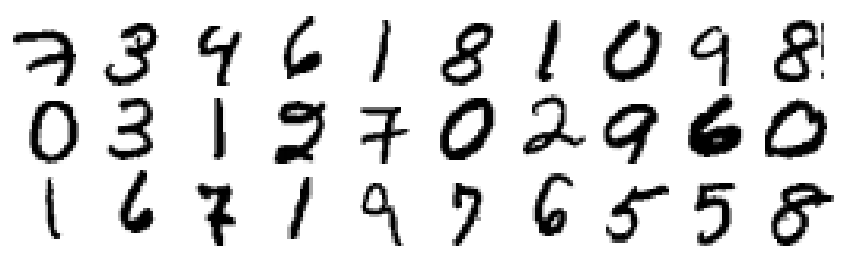

In [4]:
samples = x_train[5000:5030,:]
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(samples[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
# # first flatten data points 
# x_train_res = x_train.reshape(60000, 784)
# x_test_res = x_test.reshape(10000, 784)

# print(x_train_res.shape, x_test_res.shape, y_train.shape, y_test.shape)

#### grid search for optimal K First Try

In [ ]:
# def dist(u, v):
#     res = np.sqrt((u[0]-v[0])**2 + (u[1]-v[1])**2)
#     return res

@cuda.jit()
def distance_value(data_point, dataset, out):
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    #TODO: write a kernel to compute the distance matrix of the input "mat" and place the result in "out"
    # you can optimaze it: calculate half and copy in simetrik box
    if row < 28 and col < 28:
      
      idx = 0
      for i in range(len(dataset)):
        result = 0.0
        data = dataset[i]
        for r in range(28):
          for c in range(28):
            result += (data_point[r,c] - data[r,c])**2
        
        out[idx] = result
        idx += 1

In [ ]:
def find_distances(x, X):
    result = []
    # TODO: Compute the list of distances from x to each point in X
    A_global_mem = cuda.to_device(x)
    B_global_mem = cuda.to_device(X)
    C_global_mem = cuda.device_array((X.shape[0]), np.float32)

    threadsperblock = (28, 28)

    blockspergrid_x = math.ceil(X.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(X.shape[0] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    distance_value[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
        
    C = C_global_mem.copy_to_host()

    return C
        
        


In [ ]:
from collections import Counter
def prediction(x, X, y, k=3):

    C = find_distances(x=x, X=X)
    indices = np.argsort(C)

    labels = y[indices < k]
    print(labels)

    pred = Counter(labels).most_common(1)

    return int(pred[0][0]), Counter(labels)

In [ ]:
record = []
for x in range(len(x_train[30:33])):
    pred, labels = prediction(x_train[x], x_train, y_train, k=4)
    record.append((y_train[x], pred ))

[5 9 6 8]
[5 9 7 5]
[5 1 3 2]


In [ ]:
print(record)

[(5, 5), (0, 5), (4, 5), (1, 5), (9, 9), (2, 8), (1, 0), (3, 8), (1, 7), (4, 7), (3, 6), (5, 4), (3, 6), (6, 0), (1, 1)]


In [ ]:
a=0
for i in record:
  if i[0]==i[1]:
    a+=1
print(len(record), a)

15 3


In [ ]:
import os
path = os.getcwd()
file_path = path + "/example.txt"

In [ ]:
with open(file_path, 'w') as fp:
    for item in record:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

In [ ]:
from google.colab import files
files.download('example.txt')

In [ ]:
pred, labels = prediction(x_train[111], x_train, y_train, k=22)

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0]


In [ ]:
pred, labels

(1, array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0],
       dtype=uint8))

In [ ]:
print(pred)

1


In [ ]:
print(y_train[111])

3


In [ ]:
len(C)

60000

In [ ]:
min(C), max(C)

(0.0, 399807970000.0)

In [ ]:
# GRID SEARCH FOR OPTIMAL K
accs = []
for k in range(3,22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    # Better to use knn.predict() but cuML v0.11.0 has bug
    # y_hat = knn.predict(X_test)
    y_hat_p = knn.predict_proba(x_test)
    acc = (y_hat_p.to_pandas().values.argmax(axis=1)==y_test.to_array() ).sum()/y_test.shape[0]
    #print(k,acc)
    print(k,', ',end='')
    accs.append(acc)

In [ ]:
c = find_distances(x_train[5], x_train)
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.plotm

#### Grid Search for optimal K second try

In [ ]:
# We will send the train dataset and the test dataset to gpu to calculate difference matrix between each elements, 
# then we will get calculated distances for each test data to find which one the closest one 
# each thread will be responsible from one image to 

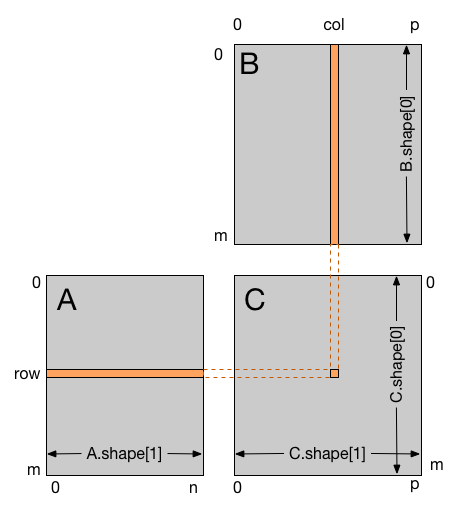

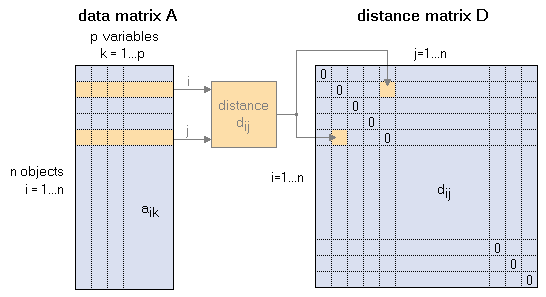

In [ ]:
# CUDA kernel
@cuda.jit
def find_differences(A, B):
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    
    if row < A.shape[0] and col < B.shape[0]:
        prod = 0.
        trd = A[row]
        tsd = B[col]
        for l in range(28):
          for k in range(28):
            prod += (trd[l, k] - tsd[l, k])**2

        C[row, col] = prod**0.5

In [11]:
# CUDA kernel
@cuda.jit
def find_differences(A, B, C):
    # get the 2D position of the thread in which it will compute the dot product of the corresponding vectors 
    row, col = cuda.grid(2)
    
    if row < A.shape[0] and col < B.shape[0]:
        prod = 0.
        trd = A[row]
        tsd = B[col]
        for l in range(28):
          for k in range(28):
            prod += (trd[l, k] - tsd[l, k])**2

        C[row, col] = prod**0.5

In [12]:
def distance_matrix(A, B):
    # A is train_dataset (60000,28,28)
    # B is test_dataset (10000,28,28)
    # Copy the input matrices to the gpu
    start_copy_time = time.time()
    A_global_mem = cuda.to_device(A)
    B_global_mem = cuda.to_device(B)

    # Allocate memory on the device for the result (Note the shape of the output matrix)
    C_global_mem = cuda.device_array((A.shape[0], B.shape[0]), np.float32)
    
    # Configure the blocks
    # Specify how many threads per block
    threadsperblock = (28, 28)
    
    #TODO: Calculate how many blocks are required
    blockspergrid_x = math.ceil(A.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(B.shape[0] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    dt = time.time()-start_copy_time
    print(f'Copying Input to GPU time: {dt} s')
    start_mult_time = time.time()
    
    #TODO: Start the kernel based on the calculated grid 
    find_differences[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

    dt = time.time()-start_mult_time
    print(f'Multiplication Time: {dt} s')
    # Copy the result back to the host
    start_copy_back_time = time.time()
    C = C_global_mem.copy_to_host()
    dt = time.time()-start_copy_back_time
    print(f'Copy result back time: {dt} s')
    dt = time.time()-start_copy_time
    print(f'Total time: {dt} s')
    return C

In [13]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [14]:
result_matrix = distance_matrix(x_train, x_test)

Copying Input to GPU time: 0.018406391143798828 s
Multiplication Time: 0.6834633350372314 s
Copy result back time: 90.94807147979736 s
Total time: 91.65037488937378 s


In [15]:
result_matrix.shape

(60000, 10000)

In [16]:
sorted_result_matrix = np.argsort(result_matrix, axis=0)

In [20]:
sorted_result_matrix.shape

(60000, 10000)

In [18]:
from collections import Counter

In [ ]:
k=3

result_list = []
for i in range(sorted_result_matrix.shape[1]):
  row_data = sorted_result_matrix[:, i]
  first_k = row_data[:k]
  labels = y_train[first_k]
  pred = Counter(labels).most_common(1)[0][0]
  real = y_train[i]
  result_list.append((i, pred, real))

In [ ]:
result_list

In [ ]:
test_row[:3]

array([10392, 21693,    96])

In [22]:
test_row = sorted_result_matrix[:, 111]
y_train[test_row[:3]], y_test[111]

(array([7, 7, 7], dtype=uint8), 7)

In [24]:
aaa = 111
test_row = sorted_result_matrix[:, aaa]
labels = y_train[test_row[:3]]
pred = Counter(labels).most_common(1)[0][0]
labels, pred, y_test[aaa]

(array([7, 7, 7], dtype=uint8), 7, 7)

In [ ]:
def prediction(index, predictions, y, k=3):

    indices = np.argsort(predictions)
    labels = y[indices < k]

    pred = Counter(labels).most_common(1)
    real = y[index]
    return int(pred[0][0]), Counter(labels), real

In [ ]:
y_train[test_row[:3]]

array([2, 2, 2], dtype=uint8)

In [ ]:
test = [7,2,3,11,5]
res = np.argsort(test)
res

array([1, 2, 4, 0, 3])

In [ ]:
pred, counter, real = prediction(19, row_data, y_train, k=3)
pred, counter, real

(0, Counter({0: 1, 4: 1}), 9)

In [ ]:
a =np.array([[1, 2, 3], [2, 4, 1], [4, 3, 2], [6, 5, 7]])
a

array([[1, 2, 3],
       [2, 4, 1],
       [4, 3, 2],
       [6, 5, 7]])

In [ ]:
ids = np.argsort(a, axis=0)
ids

array([[0, 0, 1],
       [1, 2, 2],
       [2, 1, 0],
       [3, 3, 3]])

In [ ]:
b =[10, 11, 12]

In [ ]:
aa[ids < 1]

array([1, 4, 2, 5])

In [ ]:
from collections import Counter
def prediction(index, predictions, y, k=3):

    indices = np.argsort(predictions)
    labels = y[indices < k]

    pred = Counter(labels).most_common(1)
    real = y[index]
    return int(pred[0][0]), Counter(labels), real

In [ ]:
result_matrix.shape

(60000, 10000)

In [ ]:
temp_matrix = result_matrix[:,:3]
temp_matrix.shape

(60000, 3)

In [ ]:
for i in temp_matrix.T:
  first

In [ ]:
temp_matrix = result_matrix

In [ ]:
result = []
for r in range(temp_matrix.shape[1]):
  row_data = temp_matrix[:,r]
  pred, _, real = prediction(r, row_data, y_train, k=3)
  result.append((real, pred))


In [ ]:
cnt = 0
for i in result:
  if i[0] == i[1]:
    cnt += 1

print(cnt,"/", 10000)

1031 / 10000
